In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import optuna

In [35]:
file_path = '../data/all_listings_gold.xlsx'

In [36]:
#this is the modeling transformation
df = pd.read_excel("../data/all_listings_silver.xlsx")
df = df.dropna(subset=['price_in_eur'])

# Remove severe outliers from log(price_in_eur)
df['log_price'] = np.log(df['price_in_eur'])
mean_log_price = df['log_price'].mean()
std_log_price = df['log_price'].std()
df = df[(df['log_price'] >= mean_log_price - 3 * std_log_price) & (df['log_price'] <= mean_log_price + 3 * std_log_price)]
df["log_mileage"] = np.log1p(df["Mileage_km"])


# One-hot encode the categorical variables
series_dummies = pd.get_dummies(df['Series'], prefix='series', drop_first=True).astype(int)
model_dummies = pd.get_dummies(df['model_category'], prefix='model', drop_first=True).astype(int)
state_dummies = pd.get_dummies(df['Ready to drive'], prefix='state', drop_first=True).astype(int)
transmission_dummies = pd.get_dummies(df['Transmission'], prefix='state', drop_first=True).astype(int)
drive_dummies = pd.get_dummies(df['Drive'], prefix='state', drop_first=True).astype(int)

# Also one-hot encode the additional categoricals
#interior_material_dummies = pd.get_dummies(df['Interior material'], prefix='interior_material', drop_first=True).astype(int)
interior_color_dummies = pd.get_dummies(df['Interior color'], prefix='interior_color', drop_first=True).astype(int)
matching_numbers_dummies = pd.get_dummies(df['Matching numbers'], prefix='matching', drop_first=True).astype(int)
car_location_dummies = pd.get_dummies(df['Car location'], prefix='car_location', drop_first=True).astype(int)

# Add these to the concatenation below
df = pd.concat([
    df, 
    series_dummies, 
    model_dummies, 
    state_dummies,
    #interior_material_dummies,
    #interior_color_dummies,
    matching_numbers_dummies,
    car_location_dummies,
    transmission_dummies,
    drive_dummies
], axis=1)

# Concatenate the dummy columns with the original dataframe
df.to_excel(file_path, index=False)

In [37]:
display(list(df.columns))

['URL',
 'level_0',
 'index',
 'Title',
 'Year of construction',
 'Model',
 'VIN',
 'Body',
 'Series',
 'Power',
 'Cylinder capacity',
 'Steering',
 'Transmission',
 'Drive',
 'Fuel',
 'Configuration',
 'Interior material',
 'Interior color',
 'Seat pattern',
 'Exterior color',
 'Matching numbers',
 'Vehicle inspection',
 'Condition',
 'New / used',
 'Ready to drive',
 'Registered',
 'Country of first delivery',
 'Number of vehicle owners',
 'Car location',
 'Initial registration date',
 'Mileage',
 'Manufacturer color code (exterior)',
 'Price',
 'Secondary interior color',
 'Paint-to-Sample (PTS)',
 'Vehicle inspection valid until',
 'CO2 emissions',
 'Consumption',
 'Data_Hash',
 'Scraped_At',
 'Old_Price',
 'Description',
 'Secondary_Description',
 'restoration_full',
 'restoration_partial',
 'is_restomod',
 'has_docs',
 'is_matching_numbers',
 'is_mint',
 'is_race_ready',
 'is_rare',
 'is_accident_free',
 'has_upgrades',
 'listing_score',
 'mileage_value',
 'mileage_unit',
 'owner

In [38]:
# --- Setup ---
numeric_cols = ['Mileage_sq', 'log_mileage']
categorical_cols = [
    'series_911 F-Model', 'series_911 G-Model', 'series_912', 'series_991', 'series_992',
    'series_993', 'series_996', 'series_997', 'series_981',
    'series_982', 'model_Carrera 3.0/3.2 / S / SC',
    'model_GT2RS and RARE Models', 'model_GT3 / GT2', 'model_GT3RS', 'model_RS Model',
    'model_Special / Backdate', 'model_Turbo S / Turbo', 'state_yes', 'state_Manual',
    'state_PDK', 'state_Rear drive', 'matching_yes', 'car_location_United States',
    'is_fully_restored', 'Paint-to-Sample (PTS)', 'listing_score'
]

text_features = [
    'restoration_full', 'restoration_partial', 'is_restomod', 'has_docs',
    'is_matching_numbers', 'is_mint', 'is_race_ready', 'is_rare',
    'is_accident_free', 'has_upgrades', 'first_owner'
]

0    179800.0
1     82950.0
2     87500.0
3    159900.0
4    110000.0
Name: price_in_eur, dtype: float64
Min price_in_eur: 23264.35
Max price_in_eur: 664720.0


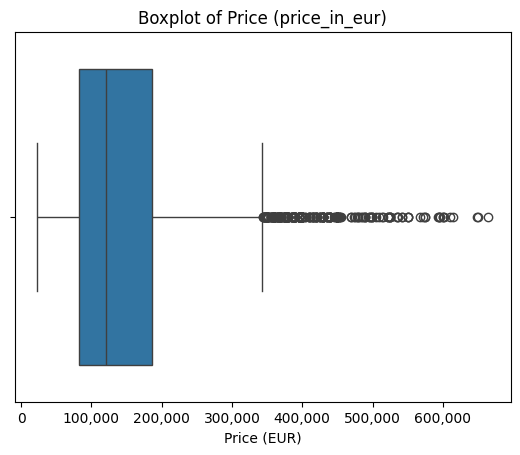

Listings below lower whisker: 0
Listings above upper whisker: 283
Total listings outside boxplot whiskers: 283
Numeric Columns Descriptive Stats:
           level_0        index  Year of construction  Secondary_Description  \
count  3229.000000  3097.000000           5438.000000                    0.0   
mean   2386.307835  2285.342912           2003.116403                    NaN   
std    1357.171482  1292.293715             17.158145                    NaN   
min       2.000000     2.000000           1964.000000                    NaN   
25%    1204.000000  1150.000000           1990.000000                    NaN   
50%    2435.000000  2342.000000           2007.000000                    NaN   
75%    3535.000000  3407.000000           2018.000000                    NaN   
max    5009.000000  4474.000000           2026.000000                    NaN   

       listing_score  mileage_value     Mileage_km    Mileage_sq  inv_mileage  \
count    5438.000000    5438.000000    5438.000000  

In [39]:
#Descriptives here
df = pd.read_excel(file_path)
bool_columns = df.select_dtypes(include=[int]).columns
for col in bool_columns:
    if df[col].isin([0, 1]).all():  # Check if the column only contains 0 and 1
        df[col] = df[col].astype(bool)

print(df['price_in_eur'].head())
print('Min price_in_eur:', df['price_in_eur'].min())
print('Max price_in_eur:', df['price_in_eur'].max())

plt.close('all')  # Clear any previous figures
plt.figure()
sns.boxplot(x=df['price_in_eur'])
plt.xscale('linear')  # Ensure linear scale
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Plain number formatting
plt.title('Boxplot of Price (price_in_eur)')
plt.xlabel('Price (EUR)')
plt.show()

# Calculate boxplot statistics
q1 = df['price_in_eur'].quantile(0.25)
q3 = df['price_in_eur'].quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr

num_below = (df['price_in_eur'] < lower_whisker).sum()
num_above = (df['price_in_eur'] > upper_whisker).sum()
print(f"Listings below lower whisker: {num_below}")
print(f"Listings above upper whisker: {num_above}")
print(f"Total listings outside boxplot whiskers: {num_below + num_above}")

# Get descriptive statistics for numeric columns
numeric_desc = df.describe()

# Get descriptive statistics for categorical columns
categorical_desc = df.describe(include=['object'])

# Get descriptive statistics for boolean columns
boolean_desc = df.describe(include=[bool])

# Print out the descriptive stats
print("Numeric Columns Descriptive Stats:")
print(numeric_desc)

print("\nCategorical Columns Descriptive Stats:")
print(categorical_desc)

print("\nBoolean Columns Descriptive Stats:")
print(boolean_desc)


In [40]:
# Linear regression model with only significant variables

# Example: your cleaned DataFrame
df = pd.read_excel(file_path)  

# --- Step 1: Define your features ---

numeric_cols = [
    'Mileage_sq',
    'log_mileage'
]

categorical_cols = [
    'series_911 F-Model',
    'series_911 G-Model',
    'series_912',
    'series_991',
    'series_992',
    'series_993',
    'series_996',
    'series_997',
    'series_981',
    'series_982',
    'model_Carrera 3.0/3.2 / S / SC',
    'model_GT2RS and RARE Models',
    'model_GT4 / GT3 / GT2',
    'model_GT3RS',
    'model_RS Model',
    'model_Special / Backdate',
    'model_Turbo S / Turbo',
    'state_yes',
    'state_Manual',
    'state_PDK',
    'state_Rear drive',
    'matching_yes',
    'car_location_United States',
    'is_fully_restored',
    'Paint-to-Sample (PTS)',
    'listing_score'
]

# No interaction columns included

# --- Step 2: Construct X and y ---
X = df[numeric_cols + categorical_cols].copy()
X = sm.add_constant(X)  # Adds the intercept

y = df['price_in_eur']

# --- Step 3: Split the data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check which columns in X_train have NaNs or infs
print(X_train.columns[X_train.isnull().any()])
print(X_train.columns[np.isinf(X_train).any()])

# Same for y_train
print("y_train NaNs:", y_train.isnull().sum())
print("y_train infs:", np.isinf(y_train).sum())


# --- Step 4: Fit the regression model ---
model = sm.OLS(np.log(y_train), X_train).fit()

# --- Step 5: Output summary ---
print(model.summary())

# --- Step 6: VIF check ---
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

# --- Step 7: Evaluate on test set ---
y_pred = model.predict(X_test)
test_r2 = r2_score(np.log(y_test), y_pred)
print(f"Test R²: {test_r2:.4f}")


Index([], dtype='object')
Index([], dtype='object')
y_train NaNs: 0
y_train infs: 0
                            OLS Regression Results                            
Dep. Variable:           price_in_eur   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     461.8
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:17:52   Log-Likelihood:                -645.77
No. Observations:                4350   AIC:                             1350.
Df Residuals:                    4321   BIC:                             1534.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [41]:
# Load data
df = pd.read_excel(file_path)
df = df.dropna(subset=['price_in_eur'])


X = df[numeric_cols + categorical_cols].copy()
X = sm.add_constant(X)
y = df['price_in_eur']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression model (log-price)
model = sm.OLS(np.log(y_train), X_train).fit()
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)

# Calculate residuals and prediction intervals
residuals_log = np.log(y_test) - y_pred_log
residual_std = residuals_log.std()
ci = 1.645  # 90% CI (one-sided)

# Residuals in log space (already calculated)
residuals_log = np.log(y_test) - y_pred_log

# Residuals in actual euros
residuals_eur = y_test - y_pred

# Lower and upper bounds in log space
pred_lower_log = y_pred_log - ci * residual_std
pred_upper_log = y_pred_log + ci * residual_std

# Convert back to price
pred_lower = np.exp(pred_lower_log)
pred_upper = np.exp(pred_upper_log)

# Results DataFrame
results_df = X_test.copy()
results_df["true_price"] = y_test
results_df["pred_price"] = y_pred
results_df["pred_lower"] = pred_lower
results_df["pred_upper"] = pred_upper
results_df["true_log_price"] = np.log(y_test)
results_df["pred_log_price"] = y_pred_log
results_df["pred_lower_log"] = pred_lower_log
results_df["pred_upper_log"] = pred_upper_log
results_df["diff_price"] = y_test-y_pred

# Merge all results with original details
full_details = df.loc[results_df.index]
all_results_df = pd.concat([full_details, results_df.drop(columns=X_test.columns)], axis=1)

# Filter for underpriced listings (true price below lower CI)
underpriced_df = results_df[
    (results_df["true_log_price"] < results_df["pred_log_price"]) &
    (results_df["true_log_price"] < results_df["pred_lower_log"])
]
underpriced_details = df.loc[underpriced_df.index]
underpriced_results_df = pd.concat([underpriced_details, underpriced_df.drop(columns=X_test.columns)], axis=1)

# Write both to Excel (each as a separate sheet)
with pd.ExcelWriter("../results/all_listings_regression_results.xlsx") as writer:
    all_results_df.to_excel(writer, sheet_name="all_results", index=False)
    underpriced_results_df.to_excel(writer, sheet_name="underpriced", index=False)

print("✅ Exported all results and underpriced listings to listings_regression_results.xlsx")


✅ Exported all results and underpriced listings to listings_regression_results.xlsx


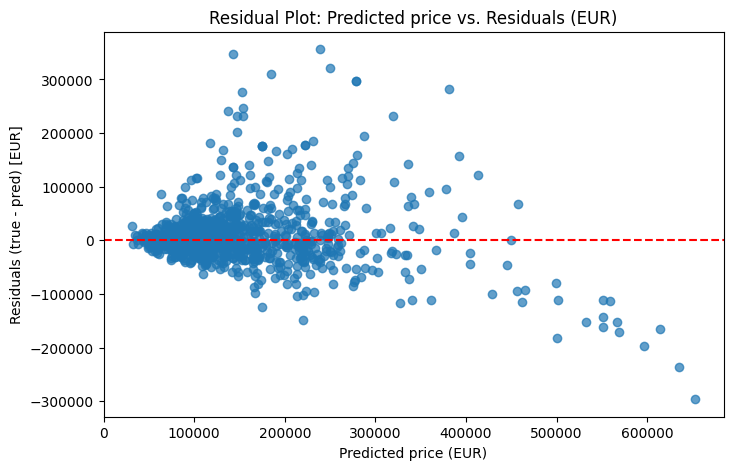

In [42]:
# Example: plot residuals in euros
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals_eur, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted price (EUR)")
plt.ylabel("Residuals (true - pred) [EUR]")
plt.title("Residual Plot: Predicted price vs. Residuals (EUR)")
plt.show()

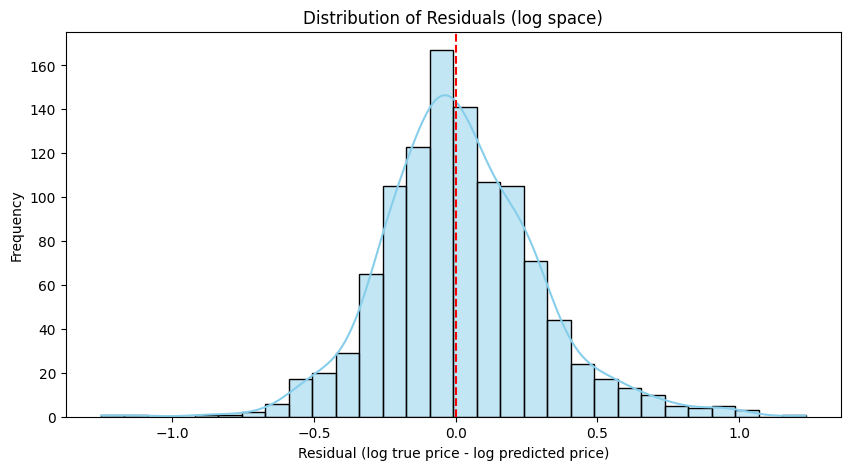

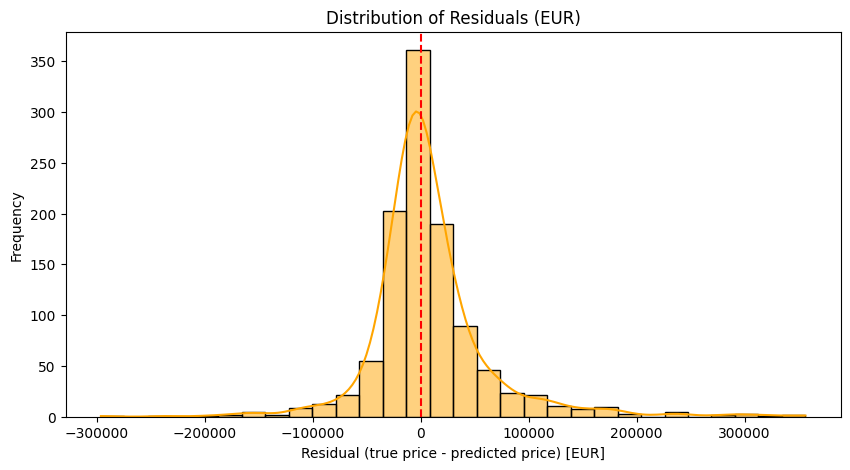

Residuals (log space):
count    1088.000000
mean        0.017927
std         0.279654
min        -1.251916
25%        -0.157672
50%        -0.004162
75%         0.182885
max         1.234473
dtype: float64

Residuals (EUR):
count      1088.000000
mean       7899.226208
std       56585.179712
min     -296212.358786
25%      -16617.263071
50%        -513.460353
75%       23021.185589
max      356275.599533
dtype: float64


In [43]:
# Plot histogram and KDE of residuals in log space
plt.figure(figsize=(10, 5))
sns.histplot(residuals_log, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (log space)")
plt.xlabel("Residual (log true price - log predicted price)")
plt.ylabel("Frequency")
plt.show()

# Plot histogram and KDE of residuals in EUR
plt.figure(figsize=(10, 5))
sns.histplot(residuals_eur, kde=True, bins=30, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (EUR)")
plt.xlabel("Residual (true price - predicted price) [EUR]")
plt.ylabel("Frequency")
plt.show()

# Print summary statistics
print("Residuals (log space):")
print(residuals_log.describe())
print("\nResiduals (EUR):")
print(residuals_eur.describe())

In [44]:
# Outliers: listings where true price is above the upper prediction interval (log scale)
outliers_df = results_df[
    (results_df["true_log_price"] > results_df["pred_log_price"]) &
    (results_df["true_log_price"] > results_df["pred_upper_log"])
]

# Get the original details for those outliers
outliers_details = df.loc[outliers_df.index]

# Find columns that overlap between outliers_df and outliers_details
overlap_cols = list(set(outliers_df.columns).intersection(set(outliers_details.columns)))

# Drop those overlapping columns from outliers_df to avoid duplicates when concatenating
outliers_df_clean = outliers_df.drop(columns=overlap_cols)

# Concatenate details and the cleaned outliers data
outliers_full_df = pd.concat([outliers_details, outliers_df_clean], axis=1)

outliers_full_df


,URL,level_0,index,Title,Year of construction,Model,VIN,Body,Series,Power,...,const,true_price,pred_price,pred_lower,pred_upper,true_log_price,pred_log_price,pred_lower_log,pred_upper_log,diff_price
2951,https://www.elferspot.com/en/car/porsche-997-2...,3793.0,3793.0,Porsche 997.2 Turbo,2013,997.2 Turbo,WP0AD2A95DS760000,Coupé,997,500 HP,...,1.0,263365.6105,150203.029771,94817.743648,237940.171159,12.481298,11.919743,11.459712,12.379775,113162.580729
1503,https://www.elferspot.com/en/car/porsche-997-2...,2102.0,2102.0,Porsche 997.2 Carrera 4 GTS,2011,997.2 Carrera 4 GTS,NaN,Cabriolet,997,408 HP,...,1.0,139900.0000,87639.410434,55323.592105,138831.662389,11.848683,11.380986,10.920955,11.841017,52260.589566
2851,https://www.elferspot.com/en/car/porsche-997-s...,3682.0,3682.0,Porsche 997 Sport Classic,2010,997 Sport Classic,NaN,Coupé,997,408 HP,...,1.0,575000.0000,278288.053099,175673.189277,440842.685308,13.262125,12.536412,12.076381,12.996443,296711.946901
5000,https://www.elferspot.com/en/car/porsche-991-2...,NaN,NaN,Porsche 991.2 Targa 4 GTS,2018,991.2 Carrera 4 GTS,WP0BB2A93JS134714,Targa,991,450 HP,...,1.0,209995.0000,124421.429378,78542.751188,197098.928345,12.254839,11.731430,11.271398,12.191461,85573.570622
746,https://www.elferspot.com/en/car/porsche-911-c...,1004.0,1004.0,Porsche 911 Carrera 3.2 Speedster,1989,911 Carrera 3.2 Speedster,NaN,Cabriolet,911 G-Model,217 HP,...,1.0,279900.0000,142736.282947,90104.256261,226111.920956,12.542188,11.868754,11.408723,12.328785,137163.717053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,https://www.elferspot.com/en/car/porsche-964-t...,4064.0,4064.0,Porsche 964 Turbo 3.6,1993,964 Turbo 3.6,wpozzz96zps470082964770,Coupé,964,360 HP,...,1.0,429000.0000,153252.219365,96742.586826,242770.464496,12.969212,11.939840,11.479809,12.399872,275747.780635
1075,https://www.elferspot.com/en/car/porsche-911-s...,1534.0,1534.0,Porsche 911 S,1971,911 S (F-Model),NaN,Coupé,911 F-Model,190 HP,...,1.0,350000.0000,147512.681926,93119.424295,233678.327521,12.765688,11.901669,11.441638,12.361701,202487.318074
4762,https://www.elferspot.com/en/car/porsche-718-s...,NaN,NaN,Porsche 718 Spyder RS,2024,718 Spyder RS,NaN,Cabriolet,982,500 HP,...,1.0,172850.0000,97053.695416,61266.489937,153745.053838,12.060179,11.483020,11.022988,11.943051,75796.304584
238,https://www.elferspot.com/en/car/porsche-911-1...,NaN,NaN,Porsche 911,1964,911 (F-Model),NaN,Coupé,911 F-Model,130 HP,...,1.0,489900.0000,142555.017260,89989.829785,225824.773695,13.101957,11.867483,11.407452,12.327515,347344.982740


In [45]:
print(df['model_category'].value_counts())
print(outliers_full_df['model_category'].value_counts())


model_category
Carrera 3.0/3.2 / S / SC      1403
Base Carrera / Targa / 912    1360
Turbo S / Turbo                663
GTS                            614
GT4 / GT3 / GT2                518
Special / Backdate             322
GT3RS                          248
RS Model                       197
GT2RS and RARE Models          113
Name: count, dtype: int64
model_category
Special / Backdate            16
GTS                           11
Carrera 3.0/3.2 / S / SC      11
Base Carrera / Targa / 912    11
Turbo S / Turbo                9
GT4 / GT3 / GT2                6
GT2RS and RARE Models          3
RS Model                       2
GT3RS                          2
Name: count, dtype: int64


In [46]:
outliers_full_df.to_excel("outliers_full_df.xlsx", index=True)

In [47]:
# Exclude outliers from the dataset and re-run OLS
# Get indices of outliers
outlier_indices = outliers_df.index

# Exclude outliers from the main DataFrame
df_no_outliers = df.drop(index=outlier_indices)

# Prepare features and target
X_no_outliers = df_no_outliers[numeric_cols + categorical_cols].copy()
X_no_outliers = sm.add_constant(X_no_outliers)
y_no_outliers = df_no_outliers['price_in_eur']

# Split data
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Fit OLS on data without outliers
model_no_outliers = sm.OLS(np.log(y_train_no_out), X_train_no_out).fit()
print(model_no_outliers.summary())

# Evaluate on test set
y_pred_no_out_log = model_no_outliers.predict(X_test_no_out)
test_r2_no_out = r2_score(np.log(y_test_no_out), y_pred_no_out_log)
print(f"Test R² without outliers: {test_r2_no_out:.4f}")


                            OLS Regression Results                            
Dep. Variable:           price_in_eur   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     483.7
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:18:03   Log-Likelihood:                -505.71
No. Observations:                4293   AIC:                             1069.
Df Residuals:                    4264   BIC:                             1254.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       